<a href="https://colab.research.google.com/github/Zemess/olio-ohjelmointi/blob/main/Syksy2024_projektitehtava.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade pip
!pip install --upgrade keras
!pip install -U -q tensorflow
#!pip show keras


In [1]:
# Nämä importattiin simple audio mallissa.
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from keras import layers
from keras import models
from IPython import display



In [2]:
import sys

import numpy as np
from keras import Model
from keras import Layer

def import_model(filepath: str) -> Model:
    """Load model from file"""
    model: Model = models.load_model(filepath)
    return model

model = import_model('model_export.keras')
print(model.summary())



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_2 (Resizing)                │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization_2 (Normalization)      │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 478,109 (1.82 MB)

 Trainable params: 159,368 (622.53 KB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 318,738 (1.22 MB)

None


In [3]:
def get_layer_weights(layer: str, model: Model) -> list[np.ndarray]:
    """Get layer weights from given model"""
    return model.get_layer(layer).get_weights()
    #Tämä hakee

def get_weights_shape(layer: list[np.ndarray]):
    tmp = []
    for i in layer:
        tmp.append(i.shape)
    return tmp



class DummyLayer(Layer):
    def __init__(self):
        super(DummyLayer, self).__init__()

    def call(self, inputs):
        return inputs

def get_reference_layer(layer: str, model: Model):
    """Split the model in to three parts start, layer and rest.

    Example:
    ```python
    model = import_model("../model/test_model.keras")
    (start, layer, end) = get_reference_layer("dense", model)

    result = start(waveform)
    layer_result = layer(result)
    print(layer_result)
    ```
    """
    modelStart = models.Sequential()
    selectedLayer: Layer
    modelEnd = models.Sequential()

    start = True
    l: Layer
    for l in model.layers:
        if l.name == layer:
            start = False
            selectedLayer = l
            continue
        if start:
            modelStart.add(l)
        else:
            modelEnd.add(l)

    if not len(modelStart.layers):
        modelStart.add(DummyLayer())
    if not len(modelEnd.layers):
        modelEnd.add(DummyLayer())

    modelStart.build(model.input_shape)
    modelEnd.build(selectedLayer.output.shape)
    return (modelStart, selectedLayer, modelEnd)



In [4]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182082353/182082353 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [5]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram



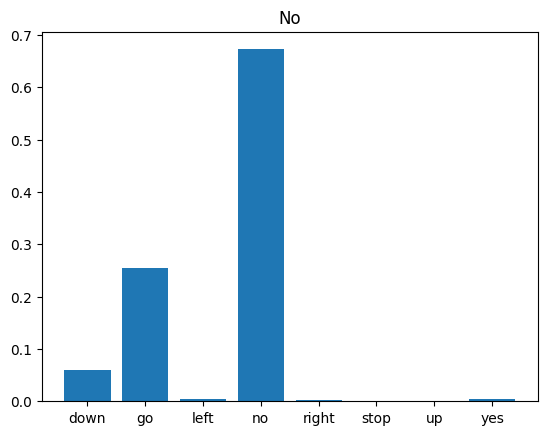

In [6]:
x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

In [ ]:
'''# Opettajan esimerkkiä.
def get_layer_weights(layer, model):
  return model.get_layer(layer).get_weights()

def get_weights_shape(layer):
  tmp = []
  for i in layer:
    tmp.append(i.shape)
  return tmp

def get_reference_layer(layer: str, model: Model):
  modelStart = models.sequential()
  selectedLayer: Layer = None
  modelEnd = models.sequential()

  start = True
  for l in model.layers:
    if l.name == layer:
      start = False
      selectedLayer = 1
      continue
    if start:
      modelStart.add(1)
    else:
      modelEnd.add(1)

  if not len(modelStart.layers):
    modelStart.add(dummyLayer())
  if not len(modelEnd.layers):
    modelEnd.add(dummyLayer())

  modelStart.build(model.input_shape)
  modelEnd.build(selectedLayer.output.shape)
  return (modelStart, selectedLayer, modelEnd)

SyntaxError: incomplete input (<ipython-input-49-d48dd3e593a9>, line 1)

In [ ]:
#input to convolutional network
#input = getWavAndCalculateSpectrogram
#1. step is to resize spectrogram "picture"
#2. step is to normalize resized picture
#3. step is to filter with N filters
#4. step is to do maxPooling (in my model)
#5. step is to do another filtering for N input and M output
#6. step is to do maxPooling (again in my model)
#7. step is to do flatten
#8. step is to do fully connected neural network layer
#9. step is to do final dense functions.
# 10. ja loppuun sittenn omalla koodilla lasketun ja alku peräisen mallin tulosten vertailu.

In [ ]:
#Step 1. On muuttaa saadun spectrogrammin kuvan kokoa.

In [ ]:
#Step 2. Normalisoidaan muutettu kuva step 1:sestä.

In [ ]:
#Step 3. On luoda filteröinti N filtereillä

In [ ]:
#Step 4. Def MaxPooling (in my model) 1: Näitä voi lisätä haluttaessa enemmän kuin 2 tarkempaa tulosta varten.
#Määritetään functio
#input_array = 2D taulukko esim kuva jolle max poolaus tehdään.
#pool_size=2 = Poolauksen koko default on 2x2
#stride      = Steppi millä Poolaus liikkuu
def maxPooling(input_array, pool_size=2, stride=2):
  #Muunnetaan tulevan kuvan ulottuvuudet
  #katsotaan korkeus ja leveys kuvasta.
  height, width = input_array.shape
  #Korkeus:
  output_height = int((height - pool_size) / stride) +1
  #Leveys:
  output_width = int((width - pool_size) / stride) +1

  #luodaan Output taulukko saaduilla korkeudella ja leveydellä.
  output_array = np.zeros((output_height, output_width))

  #Luodaan maxPooling Käydään läpi jokainen slotti i ja j paikoilla käyttäen nested looppia,
  for i in range(output_height):
    for j in range(output_width)
      start_i = i * stride
      start_j = j * stride
      end_i = start_i + pool_size
      end_j = start_j + pool_size
      pool_area = input_array[start_i:end_i, start_j:end:_j]     # katsoo kuvasta poolattavan alueen.
      output_array[i, j] = np.max(pool_area)                     # etsii maksimi arvot taulukosta.

  return output_array
  # Yksinkertaistettuna maxPool() käy läpi kuvasta saadut osat stride määrittelemien askelvälein.
  # Ja tallettaa sieltä maximi arvot output taulukkoon.

SyntaxError: incomplete input (<ipython-input-51-3f9fc36e3984>, line 1)

In [ ]:
#Step 5. Def Filterointi N inputille ja M outputille

In [13]:
#Step 9. Tästä lähtee Dense1() ja Dense2() lohkot.
def dense1(a0, w0, b0):
  a1 = np.zeros(128)
  for n in range(128):
    for w in range(len(a0[0])):
      a1[n] += a0[0][w] * w0[n,w]
    a1[n] += b0[n]
  return a1

In [ ]:
# Open Dense2
#def dense2(a0,w1,b1):
#  a1 = np.matmul(a0,w1) + b1
#  return a1

In [14]:
# Tähän tehdään neuroverkon viimeinen laskenta toka dense_1 layerille
def dense2(a1, w1, b1):
  a2 = np.zeros(len(b1))

  for i in range(len(b1)):
    for j in range(len(a0[0])):
      a2[i] += a1[0][j] * w1[j][i]
    a2[i] += b1[i]
  return np.array(a2)

In [38]:
# tähä filterointi maxpooling yms
def maxPooling(input_array, pool_size=2, stride=2):
  height, width = input_array.shape
  output_height = int((height - pool_size) / stride) +1
  output_width = int((width - pool_size) / stride) +1

  output_array = np.zeros((output_height, output_width))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_2 (Resizing)                │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization_2 (Normalization)      │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 478,109 (1.82 MB)

 Trainable params: 159,368 (622.53 KB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 318,738 (1.22 MB)

None
<Sequential name=sequential_48, built=True>
<Dense name=dense_1, built=True>
<Sequential name=sequential_49, built=True>
Output=  tf.Tensor(
[[ 0.93187475  2.3647575  -1.5796831   3.3383853  -2.4446445  -2.999572
  -3.1351159  -1.9196739 ]], shape=(1, 8), dtype=float32)
[array([[ 0.06244509,  0.18467173, -0.04301548, ...,  0.16825536,
         0.20154174,  0.11609405],
       [ 0.10436239,  0.130434  , -0.06473878, ..., -0.3043915 ,
        -0.04112712, -0.04239454],
       [ 0.17911057,  0.18802793, -0.26692376, ...,  0.09087326,
        -0.21523035,  0.15230945],
       ...,
       [ 0.15592687,  0.16070499,  0.12058023, ...,  0.24381238,
        -0.00069002,  0.05697256],
       [-0.2911123 , -0.09401824,  0.19634238, ...,  0.01280876,
         0.16788827,  0.08517853],
       [ 0.0841013 , -0.05393842,  0.0003505 , ..., -0.32859474,
        -0.33417115,  0.08200909]], dtype=float32), array([ 0.019067  ,  0.02013776,  0.03869538,  0.01013786, -0.05180661,
       -0.0671618 ,  0

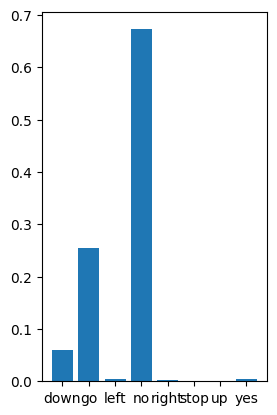

In [40]:
def flatten(input_array):
  flattenTulo = []
  for element in input_array:
    if isinstance(element, (list, tuple, np.ndarray)):
      flattenTulo.extend(flatten(element))
    else:
      flattenTulo.append(element)
  return flattenTulo
# Tällä Koodilohkolla 1 arvosana.
def omaDense1(input, name):
  w, b = get_layer_weights(name, model)
  out = np.matmul(input, w) + b
  return out

def omaDense2(input, name):
  w, b = get_layer_weights(name, model)
  print("shape d2 input= ", input.shape)
  print("shape d2 w= ", w.shape)
  print("shape d2 b= ", b.shape)
  toka,eka = w.shape
  out = np.zeros(eka)
  for i in range(eka):
    for j in range(toka):
      out[i] = out[i] + w[j,i] * input[0,j]
    out[i] = out[i] + b[i]
  return out

x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

print(model.summary())
layerName = "dense_1"
(start, layer, end) = get_reference_layer(layerName, model)
print(start)
print(layer)
print(end)
input = start(x)

output = layer(input)
print("Output= ",output)

painoArvot = get_layer_weights(layerName, model)
print(painoArvot)

omaDenseResult = omaDense2(input, layerName)
print(omaDenseResult)
flattenOmaDense = flatten(omaDenseResult)
print("Flattenin oma tulo= ",flattenOmaDense)

x_labels = ['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']
plt.figure(1)
plt.subplot(1,2,1)
plt.bar(x_labels, tf.nn.softmax(flattenOmaDense))
#plt.title('No')
plt.show()



Dense1:

<Sequential name=sequential_4, built=True>
<Dense name=dense, built=True>
<Sequential name=sequential_5, built=True>
[(512, 128), (128,)]

Dense2:

<Sequential name=sequential_6, built=True>
<Dense name=dense_1, built=True>
<Sequential name=sequential_7, built=True>
[(128, 8), (8,)]
oma tulos =  [ 0.93187482  2.36475751 -1.57968337  3.33838493 -2.44464485 -2.99957204
 -3.13511582 -1.91967409]


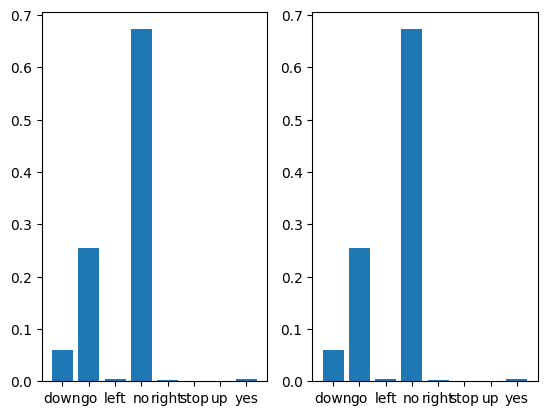

In [15]:
'''
Homma kannattaisi aloittaa verkon loppupäästä
'''
print("\nDense1:\n")
(start, layer, end) = get_reference_layer("dense", model)
weights_dense1 = get_layer_weights("dense", model)
print(start)
print(layer)
print(end)
print(get_weights_shape(get_layer_weights("dense",model)))
weights1 = get_layer_weights("dense",model)
print("\nDense2:\n")
(start, layer, end) = get_reference_layer("dense_1", model)
print(start)
print(layer)
print(end)
#print(get_layer_weights("dense_1",model))
print(get_weights_shape(get_layer_weights("dense_1",model)))
weights = get_layer_weights("dense_1",model)

# To use the model parts, call the part with the input data
result = start(x)             # tämä antaa siis verkon oikean tuloksen ennen viimeistä dense_1
                              # layeriä
layer_result = layer(result)  # Ja tämä tuloksen dense_1:n jälkeen
a0 = result                   # viimeiseen neuroverkon kerrokseen menevät 128 neuronia inputtina
w1 = weights[0]
b1 = weights[1]
w0 = weights1[0]
b0 = weights1[1]
#print("result Shape= ", layer_result.shape)
#print("w1 = ", w1)
#print("w1 shape = ", w1.shape)
#print("b1 = ", b1)
#print("b1 shape = ", b1.shape)
dense1_oma_result= dense1(a0,w0,b0)
layer_oma_result= dense2(a0,w1,b1)

print("oma tulos = ",layer_oma_result)
layer_oma_result= flatten(layer_oma_result)
#print("oma tulos shape = ",layer_oma_result.shape)
#print(layer_result)
#print(layer_result.shape)
#print(layer_result[0,:])
x_labels = ['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']
plt.figure(1)
plt.subplot(1,2,1)
plt.bar(x_labels, tf.nn.softmax(layer_result[0,:]))
plt.subplot(1,2,2)
plt.bar(x_labels, tf.nn.softmax(layer_oma_result))
#plt.title('No')
plt.show()


Debugger

In [ ]:
'''#Debuggaus code block.
a0 = np.random.rand(128)
w0 = np.random.rand(128, 128)
b0 = np.random.rand(128)
a1 = np.random.rand(128)
w1 = np.random.rand(8, 128)
b1 = np.random.rand(8)

np.set_printoptions(precision=2)
#Dense 2 Tulostus.
result = dense2(a1,w1,b1)
print(f"\nDense2 result shape: {result.shape}\n")
print(f"Dense2 result: {result:}")
#Dense 1 Tulostus.
result2 = dense1(a0,w0,b0)
print(f"\nDense1 result shape: {result2.shape}\n")
print(f"Dense1 result: {result2}")
#Flatten tulostus.
input = np.random.rand(10, 5)
result3 = flatten(input)
print(f"\nFlatten result shape: {result3.shape}\n")
print(f"Flatten result: {result3}")
plt.figure(figsize=(6, 3))
plt.subplot(1,2,1)
plt.bar(range(len(result)),result)
plt.title('Dense2')
plt.subplot(1,2,2)
plt.bar(range(len(result2)), result2)
plt.title('Dense1')
plt.show()
plt.subplot(1,2,1)
plt.bar(range(len(result3)), result3)
plt.title('Flatten')
plt.show()